# Imports and Helper Functions

This cell imports required libraries (`time`, `requests`, `os`, `csv`, etc.) and defines fundamental helper functions:

1. `sanitize_url(url)`: Cleans a URL by removing carriage returns, etc.
2. `download_html(url)`: Retrieves HTML content from a URL.
3. `parse_html(html)`: Extracts `<div class='g-primary'>` if present.
4. `save_to_file(content, filename)`: Saves text to a file.
5. `download_html_from_list(csv_file, interval)`: Reads a CSV of `(year, url)`, downloads HTML files, and organizes them into directories.

In [1]:
import time
import requests
import os
import csv
from bs4 import BeautifulSoup
from typing import List, Set

def sanitize_url(url: str) -> str:
    """
    Removes any unwanted characters (e.g., carriage return) from the URL.

    Args:
        url (str): The URL to sanitize.

    Returns:
        str: The sanitized URL.
    """
    return url.strip().replace('%0D', '')

def download_html(url: str) -> str:
    """
    Downloads the HTML content from the specified URL.

    Args:
        url (str): The URL to download the content from.

    Returns:
        str: The HTML content of the page.
    """
    response = requests.get(url)
    response.raise_for_status()
    return response.text

def parse_html(html: str) -> str:
    """
    Extracts the specified portion of the HTML content.

    Args:
        html (str): The HTML content to parse.

    Returns:
        str: The extracted portion of the HTML content (div.g-primary), or the full HTML if not found.
    """
    soup = BeautifulSoup(html, 'html.parser')
    target_div = soup.find('div', class_='g-primary')
    return target_div.prettify() if target_div else html

def save_to_file(content: str, filename: str) -> None:
    """
    Saves the specified content to a file.

    Args:
        content (str): The content to save.
        filename (str): The file to save the content to.
    """
    with open(filename, 'w', encoding='utf-8') as file:
        file.write(content)

def download_html_from_list(csv_file: str = "educause_agenda_url_list.csv", interval: int = 5):
    """
    Reads a CSV file (year, url) and downloads + saves the HTML contents
    in directories named 'html_{year}'. Each file is named 'educause{year}_agenda_contents_{index}.html'.

    Args:
        csv_file (str): Path to the CSV file containing year and URL columns.
        interval (int): Sleep interval in seconds between downloads (default=5).
    """
    previous_year = None
    index = 1

    # Ensure the file exists
    if not os.path.exists(csv_file):
        print(f"CSV file not found: {csv_file}")
        return

    with open(csv_file, "r", encoding="utf-8") as cf:
        reader = csv.reader(cf)
        for row in reader:
            # Each row: [year, url]
            if len(row) < 2:
                continue
            year_str, url = row[0], row[1]

            # Convert year to an integer, if possible
            try:
                year = int(year_str)
            except ValueError:
                # If the year is not a valid integer, skip
                continue

            # Reset index if a new year
            if previous_year is None or year_str != previous_year:
                index = 1
                previous_year = year_str

            # Prepare directory
            dir_name = f"html_{year_str}"
            os.makedirs(dir_name, exist_ok=True)

            sanitized_url = sanitize_url(url)
            html_content = download_html(sanitized_url)
            extracted_content = parse_html(html_content)

            # Save to file
            filename = os.path.join(dir_name, f"educause{year_str}_agenda_contents_{index}.html")
            save_to_file(extracted_content, filename)
            print(f"Downloaded to {filename}")

            index += 1
            time.sleep(interval)

# Additional Imports and Global Variables

Here, we import additional modules (`sys`, `pandas`, `matplotlib.pyplot`) for potential data processing and plotting. We also define a list of `EXCLUDED_WORDS` to exclude from search matches.

In [2]:
import sys
import pandas as pd
import matplotlib.pyplot as plt

EXCLUDED_WORDS = [
    "SAILS", "WebAIM", "CampusEAI", "MAIS", "Kuali", "FAIT", "RAI", "SAIT", "FAE",
    "NAIR", "AIMS", "HAIL", "AIR", "CFAIT", "FAIM", "SAIR", "PAIR", "AIM", "OAAI",
    "AITS", "AIP", "SUSTAIN", "EGlIAIHi31", "FAILURE", "AIF"
]

# Writing Results and Finding Matches

Contains two key functions:

- `write_results_to_file(filename, results)`: Writes a list of strings to the specified file.
- `find_matches_in_html(...)`: Parses an HTML file, locates sections or titles, and checks each line for search terms.

In [3]:
def write_results_to_file(filename: str, results: List[str]):
    """
    Write results to a file (unconditionally overwrites in this Jupyter-friendly version).

    Parameters
    ----------
    filename : str
        The path where the file will be created/overwritten.
    results : List[str]
        A list of strings to write into the file.
    """
    with open(filename, "w", encoding="utf-8") as f:
        f.write("\n".join(results))
    print(f"Results written to {filename}.")


def find_matches_in_html(
    filepath: str,
    scope: str,
    search_mode: str,
    show_lines: bool = False,
    seen_h1: Set[str] = None,
    line_checker_func=None
) -> List[str]:
    """
    Parse an HTML file and find occurrences based on search_mode and scope,
    using the provided line_checker_func to test each line.

    ...
    """
    if line_checker_func is None:
        return []

    results = []

    # Read and parse the HTML
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        soup = BeautifulSoup(f, "html.parser")

    # Decide which sections of the HTML to parse
    if scope == "title":
        sections = soup.find_all("h1")
    else:
        title_tags = soup.find_all("h1")
        content_tags = soup.find_all("div", class_="rte-section")
        sections = title_tags + content_tags

    # Optionally check for duplicate H1 content
    if seen_h1 is not None:
        h1_texts = [tag.get_text(separator="\n").strip() for tag in soup.find_all("h1")]
        for h1_text in h1_texts:
            # The original script replaces "Day 2" with "Day 1" to handle certain equivalences
            h1_text = h1_text.replace("Day 2", "Day 1")
            if h1_text in seen_h1:
                # Skip processing entire file if this <h1> was already seen
                return []
            seen_h1.add(h1_text)

    # Extract text from each target section, split into lines, and check
    for tag in sections:
        text_block = tag.get_text(separator="\n")
        lines = text_block.splitlines()
        for line in lines:
            line_stripped = line.strip()
            if line_checker_func(line_stripped, search_mode):
                if show_lines:
                    results.append(line_stripped)
                else:
                    results.append("match")

    return results

# Counting HTML Files

Provides a function `count_html_files(...)` that walks through one or more directories, finds `.html` files, and uses `find_matches_in_html` to locate specific search terms.

In [4]:
def count_html_files(
    directories: List[str],
    scope: str,
    search_mode: str,
    show_lines: bool = False,
    skip_duplicates: bool = False,
    line_checker_func=None
) -> List[str]:
    """
    Scan HTML files in multiple directories for lines containing the desired terms.
    Optionally skip files with duplicate <h1> content to avoid double-counting.

    ...
    """
    results = []
    seen_h1 = set() if skip_duplicates else None

    for directory in directories:
        if not os.path.isdir(directory):
            continue
        for root, _, files in os.walk(directory):
            for file in files:
                if file.lower().endswith(".html"):
                    filepath = os.path.join(root, file)
                    matches = find_matches_in_html(
                        filepath=filepath,
                        scope=scope,
                        search_mode=search_mode,
                        show_lines=show_lines,
                        seen_h1=seen_h1,
                        line_checker_func=line_checker_func
                    )
                    if matches:
                        # Summarize the total occurrences per file
                        results.append(f"{file}: {len(matches)} occurrences")
                        if show_lines:
                            # Optionally list out each matched line
                            results.extend(matches)

    return results

# Line Checker for 'AI'

This cell defines a function `line_contains_search_terms_ai` which checks a line against AI-related keywords, filtering out certain excluded words and handling cases like "both" (meaning both `AI` and `artificial intelligence`).

In [5]:
def line_contains_search_terms_ai(line: str, search_mode: str) -> bool:
    """
    Check if a given line contains the desired search terms for
    'AI', 'artificial_intelligence', or 'both'.

    ...
    """
    line_lower = line.lower()

    if search_mode == "AI":
        # Must contain uppercase "AI" (exact substring),
        # excluding lines that contain known exceptions.
        if "AI" in line:
            return not any(excluded.lower() in line_lower for excluded in EXCLUDED_WORDS)
        return False

    elif search_mode == "artificial_intelligence":
        # Must contain "artificial intelligence" in any case
        return "artificial intelligence" in line_lower

    elif search_mode == "both":
        # A line matches if it contains:
        #  - "artificial intelligence" (case-insensitive), OR
        #  - "AI" (uppercase only) not in EXCLUDED_WORDS
        has_artificial_intel = "artificial intelligence" in line_lower
        has_ai = (
            "AI" in line
            and not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS)
        )
        return has_artificial_intel or has_ai

    return False

# Line Checker for 'Dx' or 'Digital Transformation'

This cell defines `line_contains_search_terms_dx`, which checks for `'digital transformation'`, `'Dx'`, or both (under `"all"`) in the text line.

In [6]:
def line_contains_search_terms_dx(line: str, search_mode: str) -> bool:
    """
    Check if a given line contains 'digital transformation', 'Dx' (case-sensitive), or both.

    ...
    """
    line_lower = line.lower()
    dx_exclusions = ["F7lBDxwOe", "gs5xDx0ilF"]

    if search_mode == "dx":
        # Must contain "Dx" (exact case)
        if "Dx" in line:
            # Exclude lines containing any EXCLUDED_WORDS or dx_exclusions
            if not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS):
                if not any(excl in line for excl in dx_exclusions):
                    return True
        return False

    elif search_mode == "digital transformation":
        return "digital transformation" in line_lower

    elif search_mode == "all":
        has_digital_transformation = "digital transformation" in line_lower
        has_dx = (
            "Dx" in line
            and not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS)
            and not any(excl in line for excl in dx_exclusions)
        )
        return has_digital_transformation or has_dx

    return False

# Line Checker for 'Generative AI'

Defines `line_contains_search_terms_genai` to check lines for phrases such as "generative artificial intelligence", "generative AI", "gen AI", or "genAI" in various modes.

In [7]:
def line_contains_search_terms_genai(line: str, search_mode: str) -> bool:
    """
    Check if a given line contains:
      - 'generative artificial intelligence'
      - 'generative AI'   (case-insensitive 'generative', uppercase 'AI')
      - 'gen AI'          (case-insensitive 'gen', uppercase 'AI')
      - 'genAI'           (case-insensitive 'gen', uppercase 'AI')
    or all of the above, depending on the chosen search_mode.

    ...
    """
    line_lower = line.lower()

    # (1) generative_artificial_intelligence
    if search_mode == "generative_artificial_intelligence":
        return "generative artificial intelligence" in line_lower

    # (2) generative_AI
    elif search_mode == "generative_AI":
        phrase = "generative ai"
        pos = line_lower.find(phrase)
        if pos == -1:
            return False
        found_str = line[pos : pos + len(phrase)]
        if found_str.endswith("AI"):
            return not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS)
        return False

    # (3) gen_AI
    elif search_mode == "gen_AI":
        phrase = "gen ai"
        pos = line_lower.find(phrase)
        if pos == -1:
            return False
        found_str = line[pos : pos + len(phrase)]
        if found_str.endswith("AI"):
            return not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS)
        return False

    # (4) genAI
    elif search_mode == "genAI":
        phrase = "genai"
        pos = line_lower.find(phrase)
        if pos == -1:
            return False
        found_str = line[pos : pos + len(phrase)]
        if found_str.endswith("AI"):
            return not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS)
        return False

    # (5) all
    elif search_mode == "all":
        # a) generative artificial intelligence
        if "generative artificial intelligence" in line_lower:
            return True

        # b) generative AI
        phrase = "generative ai"
        pos = line_lower.find(phrase)
        if pos != -1:
            found_str = line[pos : pos + len(phrase)]
            if found_str.endswith("AI"):
                if not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS):
                    return True

        # c) gen AI
        phrase = "gen ai"
        pos = line_lower.find(phrase)
        if pos != -1:
            found_str = line[pos : pos + len(phrase)]
            if found_str.endswith("AI"):
                if not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS):
                    return True

        # d) genAI
        phrase = "genai"
        pos = line_lower.find(phrase)
        if pos != -1:
            found_str = line[pos : pos + len(phrase)]
            if found_str.endswith("AI"):
                if not any(excl.lower() in line_lower for excl in EXCLUDED_WORDS):
                    return True

        return False

    return False

# Counting Files for a Given Year & Producing CSV Output

This cell defines:
- `count_files_for_search(year, line_checker_func, search_mode, ...)`: Counts how many files in `html_{year}` have matches.
- `produce_csv_output(start_year, end_year)`: Iterates years, produces lines like `Year,AI,genAI,Dx`.

In [8]:
def count_files_for_search(
    year: int,
    line_checker_func,
    search_mode: str,
    scope: str = "title_and_content",
    skip_duplicates: bool = True
) -> int:
    """
    For a given year, call `count_html_files(...)` on directory 'html_{year}'
    with the specified line_checker_func and search_mode.
    Then count how many files had at least one match.
    """
    directory = f"html_{year}"
    results = count_html_files(
        directories=[directory],
        scope=scope,
        search_mode=search_mode,
        show_lines=False,
        skip_duplicates=skip_duplicates,
        line_checker_func=line_checker_func
    )
    # Each matched file is indicated by a line "filename.html: X occurrences"
    count = sum(1 for line in results if line.endswith("occurrences"))
    return count

def produce_csv_output(start_year: int, end_year: int) -> List[str]:
    """
    Produce CSV lines of the form:
      Year,AI,genAI,Dx
    for each year in [start_year .. end_year].
    """
    csv_lines = ["Year,AI,genAI,Dx"]
    for year in range(start_year, end_year + 1):
        ai_count = count_files_for_search(
            year=year,
            line_checker_func=line_contains_search_terms_ai,
            search_mode="both"
        )
        genai_count = count_files_for_search(
            year=year,
            line_checker_func=line_contains_search_terms_genai,
            search_mode="all"
        )
        dx_count = count_files_for_search(
            year=year,
            line_checker_func=line_contains_search_terms_dx,
            search_mode="all"
        )
        csv_lines.append(f"{year},{ai_count},{genai_count},{dx_count}")

    return csv_lines

# Plotting and Visualization

Here we define:
- `generate_default_output_name(input_file, ext)`: Creates a default output filename (e.g., `keyword_count_plot.pdf`).
- `do_visualize(...)`: A lower-level function that plots CSV data and saves the figure.

In [9]:
def generate_default_output_name(input_file: str, ext: str) -> str:
    """
    Generate a default output filename based on the input file and extension.
    """
    base_name, _ = os.path.splitext(input_file)
    return f"{base_name}_plot.{ext}"


def do_visualize(csv_file, start_year=None, output=None, ext="pdf", font_scale=1.0):
    """
    Visualize CSV data with flexible column support, optionally filtering by a 
    starting year. This function is typically invoked by `visualize_csv(...)`.

    ...
    """
    # Apply font scaling
    plt.rcParams.update({
        'font.size': 10 * font_scale,
        'axes.labelsize': 12 * font_scale,
        'axes.titlesize': 14 * font_scale,
        'legend.fontsize': 10 * font_scale,
        'xtick.labelsize': 10 * font_scale,
        'ytick.labelsize': 10 * font_scale
    })

    # Load the CSV file
    data = pd.read_csv(csv_file)

    # Validate CSV structure
    if "Year" not in data.columns:
        raise ValueError("CSV file must have a 'Year' column.")

    # Filter by starting year if specified
    if start_year:
        data = data[data["Year"] >= start_year]

    # Cycle of markers
    markers = ['o', 's', '^', 'D', 'x', 'v', 'p', 'h']
    columns_to_plot = [col for col in data.columns if col != "Year"]

    # Plot the data
    plt.figure(figsize=(10, 6))
    for i, column in enumerate(columns_to_plot):
        marker_index = i % len(markers)
        plt.plot(
            data["Year"], data[column],
            marker=markers[marker_index],
            label=column
        )

    plt.xlabel("Year")
    plt.ylabel("Count")
    plt.legend()
    plt.grid(True)

    # Determine output filename
    output_file = output if output else generate_default_output_name(csv_file, ext)

    plt.savefig(output_file)
    print(f"Plot saved to {output_file}")

# High-Level Entry Points

Here we define:
- `count_keywords(...)`: Loops over years, calls `produce_csv_output(...)`, and writes or prints the results.
- `visualize_csv(...)`: Public function that wraps `do_visualize(...)` for a typical usage scenario.

In [10]:
def count_keywords(
    start_year: int = 2000,
    end_year: int = 2024,
    output_csv: str = "keyword_count.csv",
    only_csv: bool = False
):
    """
    Count AI/GenAI/Dx occurrences in HTML directories from `start_year` to `end_year`.

    ...
    """
    csv_data = produce_csv_output(start_year, end_year)

    if only_csv:
        # Print to stdout
        print("\n".join(csv_data))
    else:
        # Write to file (no overwrite prompt in this Jupyter-friendly version)
        write_results_to_file(output_csv, csv_data)

def visualize_csv(
    csv_file: str,
    start_year: int = None,
    output: str = None,
    ext: str = "pdf",
    font_scale: float = 1.0
):
    """
    Visualize CSV data with flexible column support, optionally filtering by a 
    starting year. Saves to `output` (default PDF) if specified.

    ...
    """
    do_visualize(
        csv_file=csv_file,
        start_year=start_year,
        output=output,
        ext=ext,
        font_scale=font_scale
    )

# Main Script Invocation

If you run this as a script (rather than a notebook), the following block will:

1. Optionally download HTML files from `educause_agenda_url_list.csv`.
2. Count keywords in directories named `html_XXXX` for the years 2000 to 2024.
3. Visualize the results into a PNG file starting from 2014.

Results written to keyword_count.csv.
Plot saved to keyword_count.png


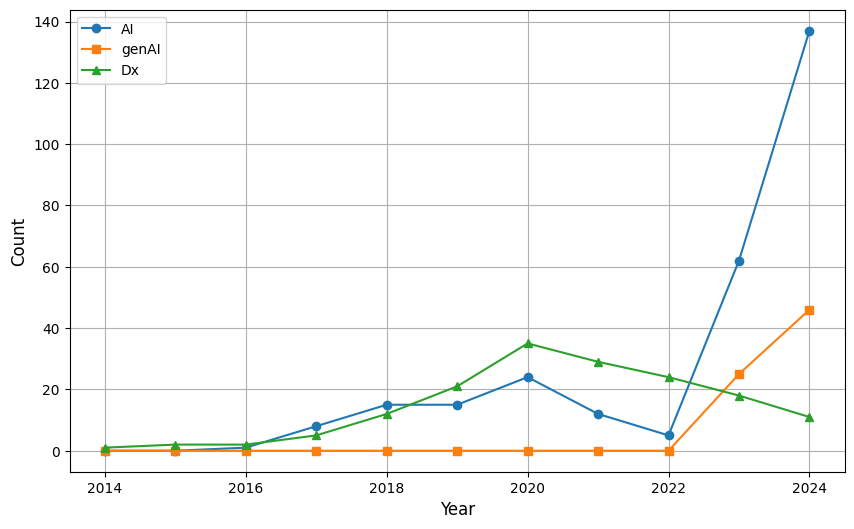

In [11]:
if __name__ == "__main__":
    # 1. Download HTML from the list (uncomment if you want to run it)
    # download_html_from_list("educause_agenda_url_list_minimum.csv", interval=5)
    # download_html_from_list("educause_agenda_url_list.csv", interval=5)

    # 2. Count keywords from 2000 to 2024
    count_keywords(2000, 2024, "keyword_count.csv", only_csv=False)

    # 3. Visualize the results (plot starting from 2014), saving as PNG
    visualize_csv("keyword_count.csv", start_year=2014, output="keyword_count.png", ext="png", font_scale=1.0)